#### Credit Scoring Model
* [SeriousDlqin2yrs] ----> (#Person experienced 90 days past due delinquency or worse (Target variable / label))
* [RevolvingUtilizationOfUnsecuredLines] ----> (#Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits)
* [age] ----> (#Age of borrower in years)
* [NumberOfTime30-59DaysPastDueNotWorse] ----> (#Number of times borrower has been 30-59 days past due but no worse in the last 2 years)
* [DebtRatio] ----> (#Monthly debt payments, alimony,living costs divided by monthy gross income)
* [MonthlyIncome] ----> (#Monthly income)
* [NumberOfOpenCreditLinesAndLoans] ----> (#Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)
* [NumberOfTimes90DaysLate] ----> (#Number of times borrower has been 90 days or more past due)
* [NumberRealEstateLoansOrLines] ----> (#Number of mortgage and real estate loans including home equity lines of credit)
* [NumberOfTime60-89DaysPastDueNotWorse] ----> (#Number of times borrower has been 60-89 days past due but no worse in the last 2 years)
* [NumberOfDependents] ----> (#Number of dependents in family excluding themselves (spouse, children etc.))

In [1]:
import numpy as np # linearna algebra
import pandas as pd # obdelava podatkov
import matplotlib

#vizualizacija podatkov
%matplotlib inline 
import seaborn as sns 
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

# ML Modeli:
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier


# Python utilities:
import time
import os

# Other
from collections import Counter
from scipy.stats import iqr
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV

#### 1) Uvoz in analiza podatkov

In [2]:
train = pd.read_csv(r"C:\Users\Miha\Desktop\Credit Scoring\cs-training.csv").drop('Unnamed: 0', axis = 1)
train.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

In [3]:
train.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'NumberOfTime30to59DaysPastDueNotWorse'}, inplace=True)
train.rename(columns={'NumberOfTime60-89DaysPastDueNotWorse':'NumberOfTime60to89DaysPastDueNotWorse'}, inplace=True)

In [4]:
train.tail(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
149990,0,0.055518,46,0,0.609779,4335.0,7,0,1,0,2.0
149991,0,0.104112,59,0,0.477658,10316.0,10,0,2,0,0.0
149992,0,0.871976,50,0,4132.000000,NaN,11,0,1,0,3.0
149993,0,1.000000,22,0,0.000000,820.0,1,0,0,0,0.0
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0
149999,0,0.850283,64,0,0.249908,8158.0,8,0,2,0,0.0


In [5]:
train.shape

(150000, 11)

In [6]:
# preverim null vrednosti v tabeli
train.isnull().sum()

SeriousDlqin2yrs                             0
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30to59DaysPastDueNotWorse        0
DebtRatio                                    0
MonthlyIncome                            29731
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60to89DaysPastDueNotWorse        0
NumberOfDependents                        3924
dtype: int64

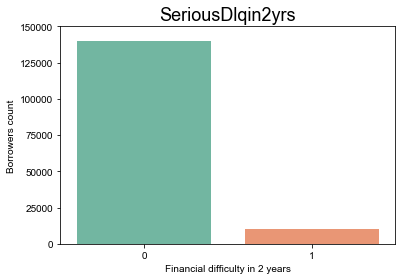

In [7]:
r = sns.countplot(x = train.SeriousDlqin2yrs , palette="Set2")
sns.set(font_scale=1.5)
r.set_ylim(top = len(train))
r.set_xlabel('Financial difficulty in 2 years')
r.set_ylabel('Borrowers count')
plt.title('SeriousDlqin2yrs')

plt.show()

#### 2) Iskanje ekstremov/izjem (Outlier detection)

###### Definicija:
In order to be an outlier, the data value must be:
* larger than Q3 by at least 1.5 times the interquartile range (IQR), or,
* smaller than Q1 by at least 1.5 times the IQR.

IQR = Q3 - Q1

In [8]:
train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


##### 2.1) Podrobnejša analiza RevolvingUtilizationOfUnsecuredLines -- obstajajo npr. vrednosti blizu 50000

In [9]:
# prikaz na kakšen način zgornji loop išče outliers-e
train.RevolvingUtilizationOfUnsecuredLines.describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [10]:
Q3_ruul = np.percentile(train.RevolvingUtilizationOfUnsecuredLines,75)
IQR_ruul = iqr(train.RevolvingUtilizationOfUnsecuredLines)
Outlier_ruul = Q3_ruul + (1.5 * IQR_ruul)
Outlier_ruul

1.35281445575

In [11]:
train[train['RevolvingUtilizationOfUnsecuredLines'] > Outlier_ruul]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
226,1,1.953488,38,0,0.153500,3556.0,5,0,0,0,2.0
293,0,2340.000000,45,0,0.339333,8333.0,7,0,2,0,2.0
697,1,2066.000000,58,0,0.271121,6000.0,8,1,1,0,1.0
900,0,2.258964,33,2,0.032484,2000.0,1,1,0,0,2.0
919,1,1.362142,73,1,274.000000,NaN,2,3,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
149245,0,771.000000,52,0,0.832021,8000.0,13,0,3,0,0.0
149279,0,20514.000000,42,0,0.062102,9902.0,1,1,0,0,2.0
149663,1,1.744511,49,0,1.224310,2500.0,4,4,2,1,1.0
149778,0,1.383886,26,2,0.247826,1839.0,3,1,0,1,0.0


Median: 0.1541807 
Mean: 6.0484381
Values less than Outlier_ruul: 149237 in 150000. Ratio: 99.49133%


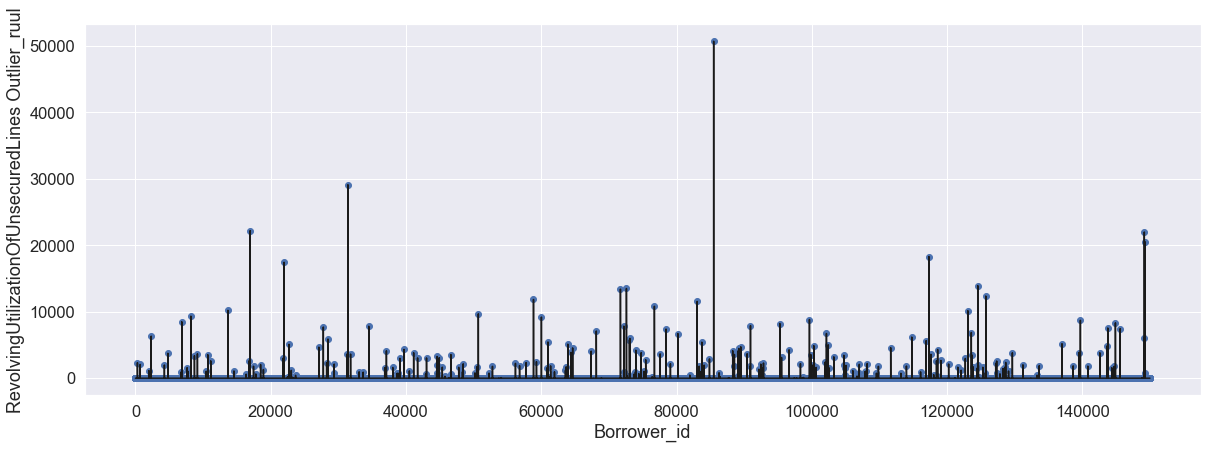

In [12]:
plt.figure(figsize=(20,15))
ax = plt.subplot(211)
plt.plot(train.RevolvingUtilizationOfUnsecuredLines, 'bo',train.RevolvingUtilizationOfUnsecuredLines, 'k')
print('Median: %.7f \nMean: %.7f' %(np.median(train.RevolvingUtilizationOfUnsecuredLines),np.mean(train.RevolvingUtilizationOfUnsecuredLines)))
ruoelLt2=len(train[train.RevolvingUtilizationOfUnsecuredLines < Outlier_ruul])
ruoelACt=len(train.RevolvingUtilizationOfUnsecuredLines)
print('Values less than Outlier_ruul: %d in %d. Ratio: %.5f%%' %(ruoelLt2,ruoelACt,100*ruoelLt2/ruoelACt))

plt.ylabel('RevolvingUtilizationOfUnsecuredLines Outlier_ruul')
plt.xlabel('Borrower_id')

plt.show()

###### Iz DF odstranim vse outliers-e

In [13]:
train[train['RevolvingUtilizationOfUnsecuredLines'] > Outlier_ruul]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
226,1,1.953488,38,0,0.153500,3556.0,5,0,0,0,2.0
293,0,2340.000000,45,0,0.339333,8333.0,7,0,2,0,2.0
697,1,2066.000000,58,0,0.271121,6000.0,8,1,1,0,1.0
900,0,2.258964,33,2,0.032484,2000.0,1,1,0,0,2.0
919,1,1.362142,73,1,274.000000,NaN,2,3,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
149245,0,771.000000,52,0,0.832021,8000.0,13,0,3,0,0.0
149279,0,20514.000000,42,0,0.062102,9902.0,1,1,0,0,2.0
149663,1,1.744511,49,0,1.224310,2500.0,4,4,2,1,1.0
149778,0,1.383886,26,2,0.247826,1839.0,3,1,0,1,0.0


In [14]:
train = train[train['RevolvingUtilizationOfUnsecuredLines'] <= Outlier_ruul]

In [15]:
train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
count,149237.000000,149237.000000,149237.000000,149237.000000,149237.000000,1.196900e+05,149237.000000,149237.000000,149237.000000,149237.00000,145338.000000
mean,0.065607,0.316992,52.328317,0.419661,353.169945,6.671913e+03,8.467525,0.262931,1.019834,0.23925,0.756808
std,0.247595,0.349765,14.771752,4.202747,2041.380555,1.441249e+04,5.147660,4.177966,1.130284,4.16522,1.114842
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.029579,41.000000,0.000000,0.175182,3.400000e+03,5.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.151895,52.000000,0.000000,0.366527,5.400000e+03,8.000000,0.000000,1.000000,0.00000,0.000000
75%,0.000000,0.549296,63.000000,0.000000,0.866580,8.250000e+03,11.000000,0.000000,2.000000,0.00000,1.000000
max,1.000000,1.352159,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.00000,20.000000


##### 2.2) Podrobnejša analiza age (outliers)

count    149237.000000
mean         52.328317
std          14.771752
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

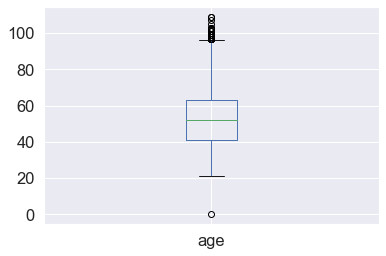

In [16]:
plt.figure(1)
train.age.plot.box()
Counter(train.age)
train.age.describe()

In [17]:
train.groupby('age').age.count()

age
0        1
21     182
22     430
23     637
24     811
      ... 
102      3
103      3
105      1
107      1
109      2
Name: age, Length: 86, dtype: int64

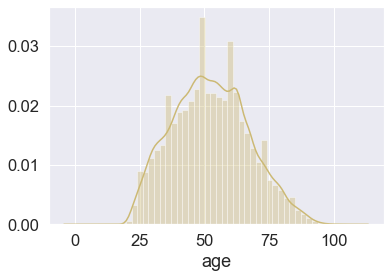

Outliers if age > 96.0


In [18]:
plt.figure(2)
sns.set_color_codes()
sns.distplot(train.age, color="y")
plt.show()

Q3_age = np.percentile(train.age,75)
IQR_age = iqr(train.age)
Outlier_age = Q3_age + (1.5 * IQR_age)
Outlier_age
print('Outliers if age >', Outlier_age) 

###### Dejansko ni večjih ekstremov - podatka "age" ne bom popravljal

##### 2.3) Podrobnejša analiza MonthlyIncome (outliers)

In [19]:
train.groupby('MonthlyIncome').MonthlyIncome.count()

MonthlyIncome
0.0          1629
1.0           604
2.0             6
4.0             2
5.0             2
             ... 
835040.0        1
1072500.0       1
1560100.0       1
1794060.0       1
3008750.0       1
Name: MonthlyIncome, Length: 13579, dtype: int64

###### Imamo tudi izjemno nizke, izredno visoke ter 'NA' vrednosti MonthlyIncome.

In [20]:
median_MonthlyIncome = train["MonthlyIncome"].astype("float").median(axis=0)
median_MonthlyIncome

5400.0

In [21]:
#NAN vrednosti nadomestim z mediano
train["MonthlyIncome"].replace(np.nan, median_MonthlyIncome, inplace=True)
#vrednosti med 0 in 10 nadomestim z mediano
train['MonthlyIncome'] = np.where(train['MonthlyIncome'].between(0,10), median_MonthlyIncome, train['MonthlyIncome'])

In [22]:
Q3_MonthlyIncome = np.percentile(train.MonthlyIncome,75)
IQR_MonthlyIncome = iqr(train.MonthlyIncome)
Outlier_MonthlyIncome = Q3_MonthlyIncome + (1.5 * IQR_MonthlyIncome)
Outlier_MonthlyIncome
print('Outliers if MonthlyIncome >', Outlier_MonthlyIncome) 

Outliers if MonthlyIncome > 12500.0


Median: 5400.0000000 
Mean: 6501.3917594


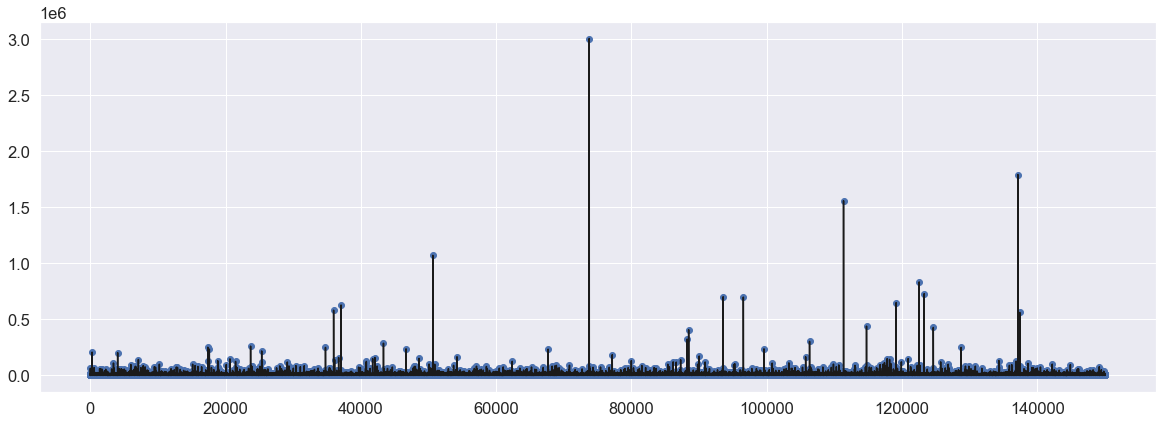

In [23]:
plt.figure(figsize=(20,15))
ax = plt.subplot(211)
plt.plot(train.MonthlyIncome, 'bo',train.MonthlyIncome, 'k')
print('Median: %.7f \nMean: %.7f' %(np.median(train.MonthlyIncome),np.mean(train.MonthlyIncome)))

###### Očitno gre res za posamezne mega zaslužkarje, zato teh podatkov ne bom spreminjal.

In [24]:
train.groupby('MonthlyIncome').MonthlyIncome.count()

MonthlyIncome
11.0         1
15.0         1
21.0         1
25.0         1
27.0         2
            ..
835040.0     1
1072500.0    1
1560100.0    1
1794060.0    1
3008750.0    1
Name: MonthlyIncome, Length: 13571, dtype: int64

##### 2.4) Podrobnejša analiza DebtRatio (outliers)

In [25]:
train.DebtRatio.describe()

count    149237.000000
mean        353.169945
std        2041.380555
min           0.000000
25%           0.175182
50%           0.366527
75%           0.866580
max      329664.000000
Name: DebtRatio, dtype: float64

In [26]:
Q3_DebtRatio = np.percentile(train.DebtRatio,75)
IQR_DebtRatio = iqr(train.DebtRatio)
Outlier_DebtRatio = Q3_DebtRatio + (1.5 * IQR_DebtRatio)
Outlier_DebtRatio
print('Outliers if DebtRatio >', Outlier_DebtRatio) 

Outliers if DebtRatio > 1.9036756469999998


Median: 0.3665267 
Mean: 353.1699453
Values less than Outlier_DebtRatio : 149237 in 149237. Ratio: 100.00000%


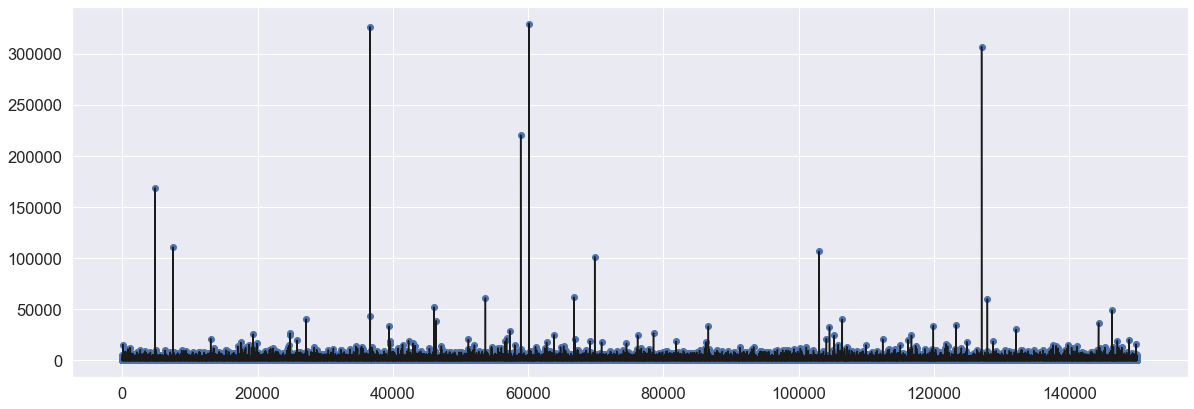

In [27]:
plt.figure(figsize=(20,15))
ax = plt.subplot(211)
#ax.set_ylim(0,20)
plt.plot(train.DebtRatio, 'bo',train.DebtRatio, 'k')
print('Median: %.7f \nMean: %.7f' %(np.median(train.DebtRatio),np.mean(train.DebtRatio)))
ruoelLt2=len(train[train.RevolvingUtilizationOfUnsecuredLines < Outlier_DebtRatio])
ruoelACt=len(train.RevolvingUtilizationOfUnsecuredLines)
print('Values less than Outlier_DebtRatio : %d in %d. Ratio: %.5f%%' %(ruoelLt2,ruoelACt,100*ruoelLt2/ruoelACt))

In [28]:
train.DebtRatio.quantile([.975])

0.975    3491.0
Name: DebtRatio, dtype: float64

Glede na podatke, 2,5 % dolžnikov dolguje cca 3500 krat več, kot imajo premoženja. Tole je sumljivo, oz. je potrebna nadaljna raziskava (ali so to outliers?)

In [29]:
#train[train['DebtRatio'] > 3491] # 3729 rows
#train[train['DebtRatio'] > 3491][['SeriousDlqin2yrs','MonthlyIncome']].describe()
train2 = train[train['DebtRatio'] > 3491]
train2.describe()
train2[train2['MonthlyIncome'] != median_MonthlyIncome]
train2[train2['DebtRatio'] > 3491][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,3729.000000,3729.0
mean,0.063824,5400.0
std,0.244472,0.0
min,0.000000,5400.0
25%,0.000000,5400.0
50%,0.000000,5400.0
75%,0.000000,5400.0
max,1.000000,5400.0


In [30]:
train[(train['DebtRatio'] > 3491) & (train['SeriousDlqin2yrs'] == 0)]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
6,0,0.305682,57,0,5710.0,5400.0,8,0,3,0,0.0
90,0,0.039388,51,0,15466.0,5400.0,7,0,0,0,0.0
109,0,0.041258,61,0,4739.0,5400.0,11,0,4,0,NaN
124,0,0.277957,39,0,4090.0,5400.0,9,0,2,0,0.0
235,0,0.000000,66,0,3730.0,5400.0,8,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149923,0,0.245212,62,0,3720.0,5400.0,16,0,2,0,0.0
149932,0,0.807021,59,0,5467.0,5400.0,19,0,2,0,0.0
149958,0,0.457101,63,0,4945.0,5400.0,9,0,1,0,0.0
149992,0,0.871976,50,0,4132.0,5400.0,11,0,1,0,3.0


Očitno so problem podatki. Gre za podatke, ki niso imeli nastavljen MonthlyIncome oz. je bil le-ta < 10 (te sem popravil na median_MonthlyIncome) Lahko jih označim kot Outliers oz. jih brišem.

###### Iz DF odstranim DebtRatio outliers-e

In [31]:
train = train[train['DebtRatio'] < 3491]

Median: 0.3560209 
Mean: 210.3698257
Values less than Outlier_DebtRatio : 145504 in 145504. Ratio: 100.00000%


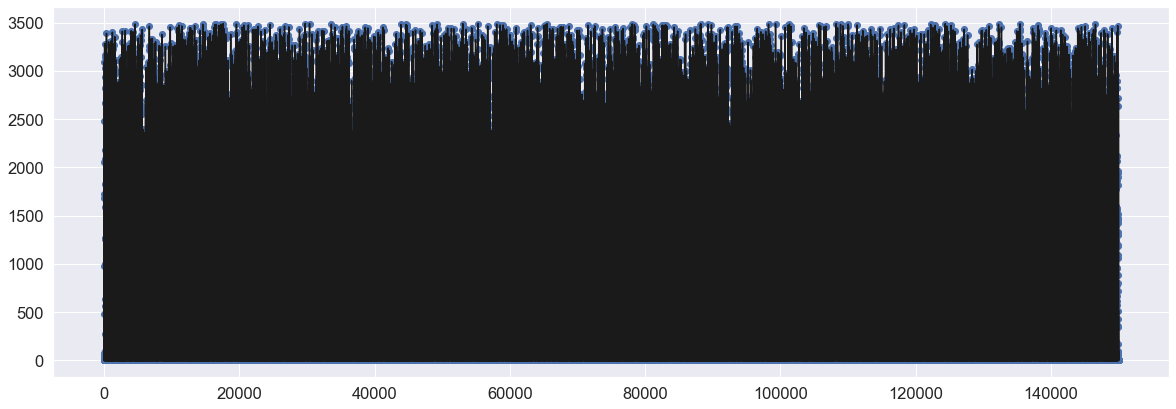

In [32]:
plt.figure(figsize=(20,15))
ax = plt.subplot(211)
#ax.set_ylim(0,20)
plt.plot(train.DebtRatio, 'bo',train.DebtRatio, 'k')
print('Median: %.7f \nMean: %.7f' %(np.median(train.DebtRatio),np.mean(train.DebtRatio)))
ruoelLt2=len(train[train.RevolvingUtilizationOfUnsecuredLines < Outlier_DebtRatio])
ruoelACt=len(train.RevolvingUtilizationOfUnsecuredLines)
print('Values less than Outlier_DebtRatio : %d in %d. Ratio: %.5f%%' %(ruoelLt2,ruoelACt,100*ruoelLt2/ruoelACt))

##### 2.5) Podrobnejša analiza NumberOfTimes90DaysLate (outliers)

In [33]:
train.groupby('NumberOfTimes90DaysLate').NumberOfTimes90DaysLate.count()
#sorted(Counter(train.NumberOfTimes90DaysLate))
#Counter(train.NumberOfTimes90DaysLate)

NumberOfTimes90DaysLate
0     137538
1       5067
2       1472
3        619
4        263
5        118
6         70
7         33
8         17
9         18
10         8
11         4
12         2
13         2
14         2
15         1
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

Zanimiva ugotovitev je, da med 17 in 96 ni vrednosti NumberOfTimes90DaysLate, za vrednost 98 pa kar 264 primerov. Gre za napako na podatkih?

In [34]:
train[train['NumberOfTimes90DaysLate'] > 95][['SeriousDlqin2yrs','NumberOfTime60to89DaysPastDueNotWorse','NumberOfTime30to59DaysPastDueNotWorse','NumberOfTimes90DaysLate']].describe()

,SeriousDlqin2yrs,NumberOfTime60to89DaysPastDueNotWorse,NumberOfTime30to59DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,269.000000,269.000000,269.000000,269.000000
mean,0.546468,97.962825,97.962825,97.962825
std,0.498764,0.270628,0.270628,0.270628
min,0.000000,96.000000,96.000000,96.000000
25%,0.000000,98.000000,98.000000,98.000000
50%,1.000000,98.000000,98.000000,98.000000
75%,1.000000,98.000000,98.000000,98.000000
max,1.000000,98.000000,98.000000,98.000000


Podatki ne zgledajo napačni, vendar bom vrednost vseeno spremenil na 18 oz 19, da ne bo tak ekstrem. To bi namreč lahko povzročilo slabši model pri algoritmih, ki so občutljivi na ekstreme - npr. SVM (random forest s tem nima težav)

In [35]:
train["NumberOfTimes90DaysLate"].replace(96, 18, inplace = True)
train["NumberOfTimes90DaysLate"].replace(98, 19, inplace = True)
#train.groupby('NumberOfTimes90DaysLate').NumberOfTimes90DaysLate.count()
train.NumberOfTimes90DaysLate.describe()

count    145504.000000
mean          0.122327
std           0.937669
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name: NumberOfTimes90DaysLate, dtype: float64

##### 2.6) Podrobnejša analiza NumberOfTime30to59DaysPastDueNotWorse ter NumberOfTime60to89DaysPastDueNotWorse (outliers)

In [36]:
#train.groupby('NumberOfTime30to59DaysPastDueNotWorse').NumberOfTime30to59DaysPastDueNotWorse.count()
#train.groupby('NumberOfTime60to89DaysPastDueNotWorse').NumberOfTime60to89DaysPastDueNotWorse.count()

#naredim enako akcijo kot pri 2.4.. Vrednosti 96%98 spremenim v 18&19
train["NumberOfTime30to59DaysPastDueNotWorse"].replace(96, 18, inplace = True)
train["NumberOfTime30to59DaysPastDueNotWorse"].replace(98, 19, inplace = True)
train["NumberOfTime60to89DaysPastDueNotWorse"].replace(96, 18, inplace = True)
train["NumberOfTime60to89DaysPastDueNotWorse"].replace(98, 19, inplace = True)

In [37]:
#train.groupby('NumberOfOpenCreditLinesAndLoans').NumberOfOpenCreditLinesAndLoans.count()
#train.groupby('NumberOfTime30to59DaysPastDueNotWorse').NumberOfTime30to59DaysPastDueNotWorse.count()
train.groupby('NumberOfTime60to89DaysPastDueNotWorse').NumberOfTime60to89DaysPastDueNotWorse.count()

NumberOfTime60to89DaysPastDueNotWorse
0     138266
1       5486
2       1033
3        298
4         95
5         32
6         15
7          6
8          2
9          1
11         1
18         5
19       264
Name: NumberOfTime60to89DaysPastDueNotWorse, dtype: int64

##### 2.7) Podrobnejša analiza NumberOfDependents (outliers)

In [38]:
train.groupby('NumberOfDependents').NumberOfDependents.count()

NumberOfDependents
0.0     83958
1.0     25849
2.0     19031
3.0      9237
4.0      2788
5.0       730
6.0       156
7.0        51
8.0        24
9.0         4
10.0        4
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

In [39]:
train.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30to59DaysPastDueNotWorse       0
DebtRatio                                   0
MonthlyIncome                               0
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60to89DaysPastDueNotWorse       0
NumberOfDependents                       3670
dtype: int64

###### 3670 strank ima null vrednost NumberOfDependents. Predvidevam, da so vrednosti prazne, ker nimajo družinskih članov, zato null vrednosti spremenim v 0.

In [40]:
#null vrednost zamenjam z 0
train["NumberOfDependents"].fillna(0, inplace = True)
#NAN vrednosti nadomestim z 0
train["NumberOfDependents"].replace(np.nan, 0, inplace=True)

##### 2.8) Podrobnejša analiza NumberOfOpenCreditLinesAndLoans (outliers)

In [41]:
train.groupby('NumberOfOpenCreditLinesAndLoans').NumberOfOpenCreditLinesAndLoans.count()

NumberOfOpenCreditLinesAndLoans
0      1880
1      4384
2      6546
3      8895
4     11393
5     12681
6     13307
7     12897
8     12191
9     10995
10     9298
11     8040
12     6729
13     5408
14     4335
15     3484
16     2859
17     2249
18     1771
19     1341
20     1097
21      809
22      648
23      499
24      388
25      307
26      220
27      183
28      143
29      106
30       83
31       69
32       51
33       43
34       33
35       25
36       18
37        7
38       12
39        9
40       10
41        4
42        8
43        7
44        2
45        8
46        3
47        2
48        6
49        4
50        2
51        2
52        3
53        1
54        4
56        2
57        2
58        1
Name: NumberOfOpenCreditLinesAndLoans, dtype: int64

In [42]:
Q3_NoOCLaL = np.percentile(train.NumberOfOpenCreditLinesAndLoans,75)
IQR_Q3_NoOCLaL = iqr(train.NumberOfOpenCreditLinesAndLoans)
Outlier_Q3_NoOCLaL = Q3_NoOCLaL + (3 * IQR_Q3_NoOCLaL) # namesto 1.5 sem podal 3 (izločim manj otliers-ov)
Outlier_Q3_NoOCLaL
print('Outliers if NumberOfOpenCreditLinesAndLoans >', Outlier_Q3_NoOCLaL) 

Outliers if NumberOfOpenCreditLinesAndLoans > 29.0


In [43]:
#naredim enako akcijo kot pri 2.4.. Vrednosti > 29 spremenim v 30
##train['NumberOfOpenCreditLinesAndLoans'] = np.where(train['NumberOfOpenCreditLinesAndLoans'].between(29,60), 30, train['NumberOfOpenCreditLinesAndLoans'])

In [44]:
#train.groupby('NumberOfOpenCreditLinesAndLoans').NumberOfOpenCreditLinesAndLoans.count().tail()

###### !!!!!ne bom spreminjal - niso takšni ekstremi

##### 2.9) Podrobnejša analiza NumberRealEstateLoansOrLines (outliers)

In [45]:
train.groupby('NumberRealEstateLoansOrLines').NumberRealEstateLoansOrLines.count()

NumberRealEstateLoansOrLines
0     55732
1     51192
2     29788
3      5646
4      1881
5       590
6       282
7       140
8        78
9        62
10       33
11       16
12       17
13       14
14        7
15        5
16        4
17        3
18        1
19        2
20        2
21        1
23        1
25        3
26        1
29        1
32        1
54        1
Name: NumberRealEstateLoansOrLines, dtype: int64

In [46]:
Q3_NoRELaL = np.percentile(train.NumberRealEstateLoansOrLines,75)
IQR_Q3_NoRELaL = iqr(train.NumberRealEstateLoansOrLines)
Outlier_Q3_NoRELaL = Q3_NoRELaL + (6 * IQR_Q3_NoRELaL) # namesto 1.5 sem podal 3 (izločim manj otliers-ov)
Outlier_Q3_NoRELaL
print('Outliers if NumberRealEstateLoansOrLines >', Outlier_Q3_NoRELaL) 

Outliers if NumberRealEstateLoansOrLines > 14.0


###### !!!!!ne bom spreminjal NumberRealEstateLoansOrLines - niso takšni ekstremi

In [47]:
#train.to_csv(r'C:\Users\Miha\Desktop\Credit Scoring\Spark\train_MJ.csv', index = False)

#### 3) Korelacija med spremenljivkami

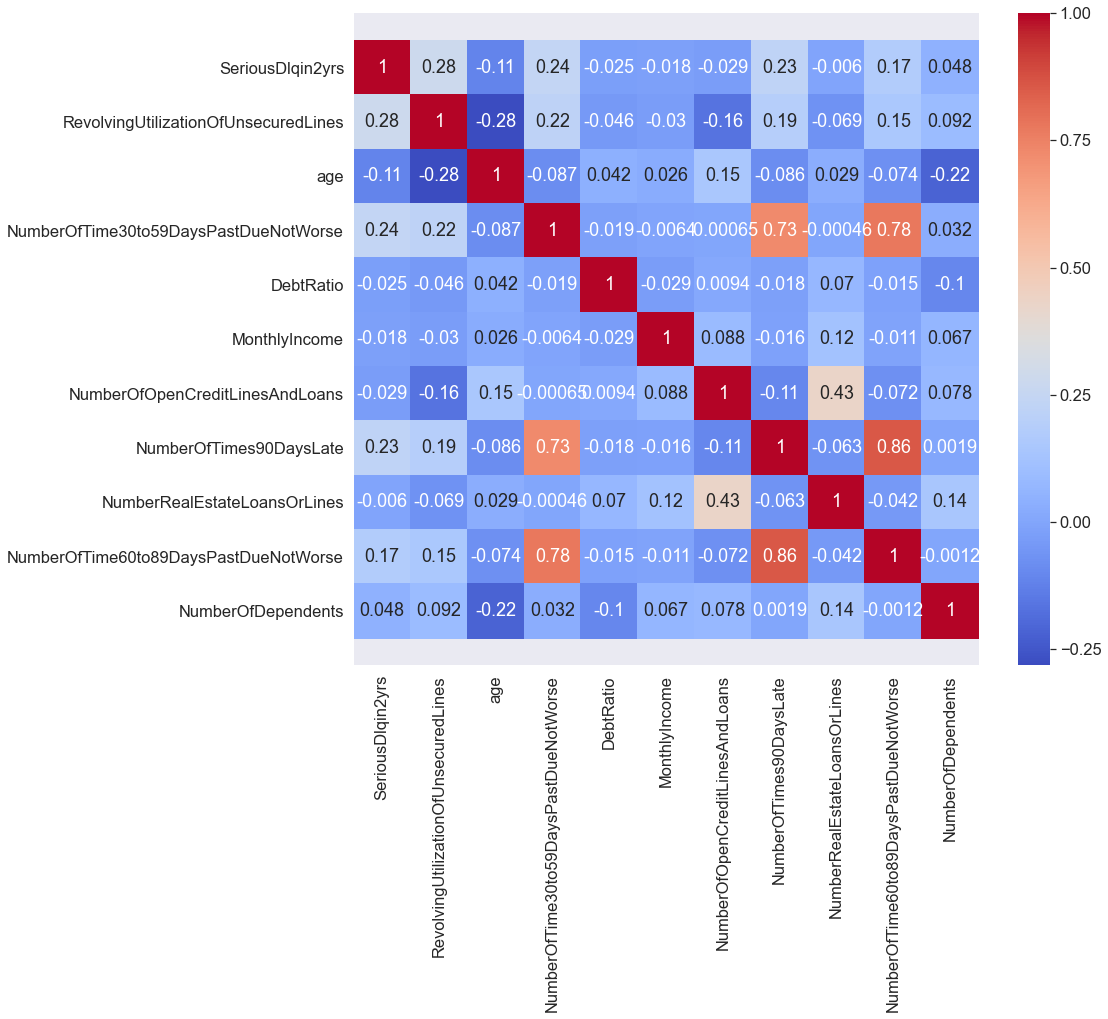

In [48]:
corr = train.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2g", cmap = "coolwarm")

#hack, ki prepreči brisanje robov
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [49]:
#train['NumberOfTime30to59DaysPastDueNotWorse'] < train['NumberOfTime60to89DaysPastDueNotWorse']
train.loc[train['NumberOfTime30to59DaysPastDueNotWorse'] < train['NumberOfTimes90DaysLate']]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
49,0,0.000080,70,0,0.256340,6900.0,21,1,1,0,0.0
68,0,0.004264,31,0,0.111444,2000.0,6,1,0,0,2.0
72,0,0.827708,56,0,0.369591,6793.0,15,1,1,0,0.0
95,0,0.245353,37,0,0.288417,6500.0,11,1,1,1,0.0
176,0,1.000000,69,0,0.005319,2255.0,0,1,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
149903,1,0.552157,55,0,0.337035,1800.0,7,1,0,0,1.0
149954,1,1.000000,46,0,170.398010,401.0,3,2,0,0,2.0
149962,0,1.005733,48,0,0.248896,2944.0,4,3,0,0,1.0
149968,1,0.983825,55,0,0.064116,4600.0,2,1,0,0,6.0


In [50]:
train.dtypes

SeriousDlqin2yrs                           int64
RevolvingUtilizationOfUnsecuredLines     float64
age                                        int64
NumberOfTime30to59DaysPastDueNotWorse      int64
DebtRatio                                float64
MonthlyIncome                            float64
NumberOfOpenCreditLinesAndLoans            int64
NumberOfTimes90DaysLate                    int64
NumberRealEstateLoansOrLines               int64
NumberOfTime60to89DaysPastDueNotWorse      int64
NumberOfDependents                       float64
dtype: object

###### Vidimo lahko, da ima target spremenljivka 'SeriousDlqin2yrs' največjo korelacijo z RevolvingUtilizationOfUnsecuredLines, NumberOfDependents ter ostalimi oblikami zamujenih odplačil.

#### 4) Model

In [51]:
outcome_feature = train['SeriousDlqin2yrs']
target_features = train.drop('SeriousDlqin2yrs', axis=1)

#outcome_feature = train.loc[:, train.columns=='SeriousDlqin2yrs']
#target_features = train.loc[:, train.columns!='SeriousDlqin2yrs']


X_train, X_test, Y_train, Y_test = train_test_split(target_features, outcome_feature, test_size=0.2)

In [52]:
print('X_train_lenght =', len(X_train))
print('Y_train_lenght =', len(Y_train))
print('X_test_lenght =', len(X_test))
print('Y_test_lenght =', len(Y_test))

X_train_lenght = 116403
Y_train_lenght = 116403
X_test_lenght = 29101
Y_test_lenght = 29101


In [53]:
# porazdelitev vrednosti odvisne spremenljivke
#Y_train.value_counts(normalize=True),2
Y_test.value_counts()

0    27240
1     1861
Name: SeriousDlqin2yrs, dtype: int64

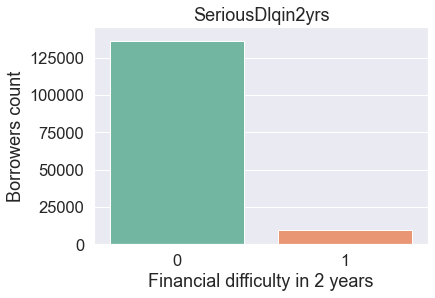

In [54]:
r = sns.countplot(x = train.SeriousDlqin2yrs , palette="Set2")
sns.set(font_scale=1.5)
r.set_ylim(top = len(train))
r.set_xlabel('Financial difficulty in 2 years')
r.set_ylabel('Borrowers count')
plt.title('SeriousDlqin2yrs')

plt.show()

##### 4.1) DecisionTreeClassifier

In [55]:
clf_dt = tree.DecisionTreeClassifier(class_weight='balanced',max_depth=6,min_impurity_decrease=0.0)
clf_dt.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6)

In [56]:
Y_pred_dt = clf_dt.predict(X_test)
pd.crosstab(Y_test, Y_pred_dt, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,21420,5820,27240
1,439,1422,1861
All,21859,7242,29101


In [57]:
accuracy_score(Y_test, Y_pred_dt)

0.7849214803614996

In [58]:
roc_auc_score(Y_test, Y_pred_dt)

0.7752244660276911

In [59]:
print(classification_report(Y_test, Y_pred_dt))

              precision    recall  f1-score   support

           0       0.98      0.79      0.87     27240
           1       0.20      0.76      0.31      1861

    accuracy                           0.78     29101
   macro avg       0.59      0.78      0.59     29101
weighted avg       0.93      0.78      0.84     29101



In [60]:
def generate_auc_roc_curve_dt(clf_dt, X_test):
    Y_pred_dt = clf_dt.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_dt)
    auc_dt = roc_auc_score(Y_test, Y_pred_dt)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_dt))
    plt.legend(loc=4)
    plt.show()
    pass

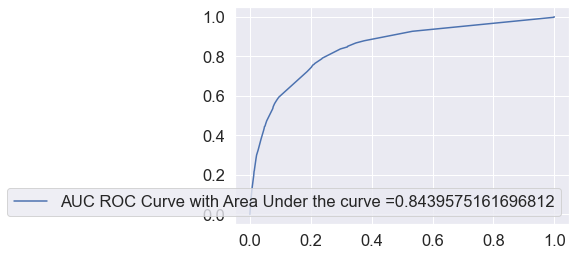

In [61]:
generate_auc_roc_curve_dt(clf_dt, X_test)

##### 4.2) LogisticRegression

In [62]:
clf_lr = linear_model.LogisticRegression(C=1e5,class_weight= {0:.1, 1:.9}, solver='liblinear')
clf_lr.fit(X_train,Y_train)

LogisticRegression(C=100000.0, class_weight={0: 0.1, 1: 0.9},
                   solver='liblinear')

In [63]:
Y_pred_lr = clf_lr.predict(X_test)
netMat = (Y_pred_lr == Y_test)
clf_lr.coef_
ind = np.where(Y_test == 1)
Counter(Y_pred_lr[ind])
pd.crosstab(Y_test, Y_pred_lr, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,23694,3546,27240
1,684,1177,1861
All,24378,4723,29101


In [64]:
accuracy_score(Y_test, Y_pred_lr)

0.854644170303426

In [65]:
roc_auc_score(Y_test, Y_pred_lr)

0.7511397287707098

In [66]:
print(classification_report(Y_test, Y_pred_lr))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92     27240
           1       0.25      0.63      0.36      1861

    accuracy                           0.85     29101
   macro avg       0.61      0.75      0.64     29101
weighted avg       0.93      0.85      0.88     29101



In [67]:
def generate_auc_roc_curve_lr(clf_lr, X_test):
    Y_pred_lr = clf_lr.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_lr)
    auc_lr = roc_auc_score(Y_test, Y_pred_lr)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_lr))
    plt.legend(loc=4)
    plt.show()
    pass

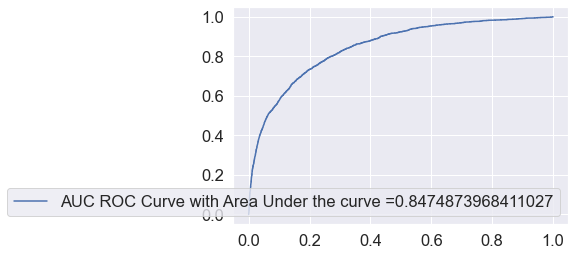

In [68]:
generate_auc_roc_curve_lr(clf_lr, X_test)

##### 4.3) Multilayer perceptron (NeuralNetwork)

In [69]:
clf_nn = MLPClassifier(activation="identity", tol= 0.1)
clf_nn.fit(X_train, Y_train)

MLPClassifier(activation='identity', tol=0.1)

###### S spremembami threshold, lahko spreminjam precision in recall

In [70]:
threshold_nn = 0.5
predicted_proba_nn = clf_nn.predict_proba(X_test)

Y_pred_nn = (predicted_proba_nn [:,1] >= threshold_nn).astype('int')
pd.crosstab(Y_test, Y_pred_nn, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,27203,37,27240
1,1830,31,1861
All,29033,68,29101


In [71]:
accuracy_score(Y_test, Y_pred_nn)

0.9358441290677296

In [72]:
roc_auc_score(Y_test, Y_pred_nn)

0.50764970714275

In [73]:
print(classification_report(Y_test, Y_pred_nn))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     27240
           1       0.46      0.02      0.03      1861

    accuracy                           0.94     29101
   macro avg       0.70      0.51      0.50     29101
weighted avg       0.91      0.94      0.91     29101



In [74]:
def generate_auc_roc_curve_nn(clf_nn, X_test):
    Y_pred_nn = clf_nn.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_nn)
    auc_nn = roc_auc_score(Y_test, Y_pred_nn)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_nn))
    plt.legend(loc=4)
    plt.show()
    pass

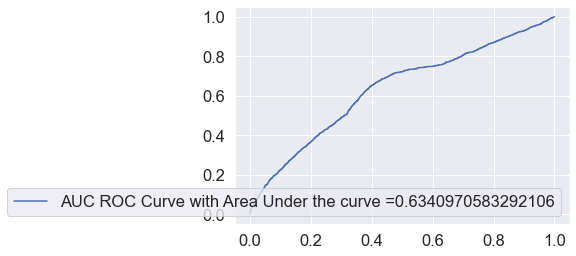

In [75]:
generate_auc_roc_curve_nn(clf_nn, X_test)

##### 4.4) RandomForest

In [76]:
clf_rf = RandomForestClassifier(n_estimators=19, max_depth = 9, random_state=0)
clf_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=9, n_estimators=19, random_state=0)

##### S spremembami threshold, lahko spreminjam precision in recall

In [77]:
threshold_rf = 0.2
predicted_proba_rf = clf_rf.predict_proba(X_test)

Y_pred_rf = (predicted_proba_rf [:,1] >= threshold_rf).astype('int')

pd.crosstab(Y_test, Y_pred_rf, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,25739,1501,27240
1,930,931,1861
All,26669,2432,29101


In [78]:
accuracy_score(Y_test, Y_pred_rf)

0.916463351774853

In [79]:
roc_auc_score(Y_test, Y_pred_rf)

0.7225829413709491

In [80]:
print(classification_report(Y_test, Y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27240
           1       0.38      0.50      0.43      1861

    accuracy                           0.92     29101
   macro avg       0.67      0.72      0.69     29101
weighted avg       0.93      0.92      0.92     29101



In [81]:
def generate_auc_roc_curve_rf(clf_rf, X_test):
    Y_pred_rf = clf_rf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_rf)
    auc_rf = roc_auc_score(Y_test, Y_pred_rf)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_rf))
    plt.legend(loc=4)
    plt.show()
    pass

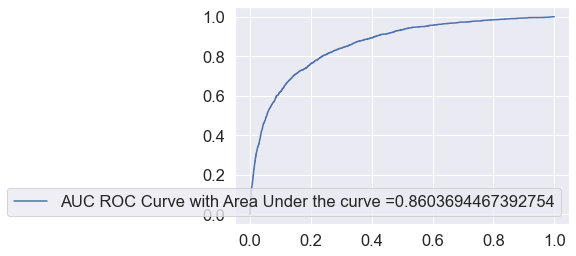

In [82]:
generate_auc_roc_curve_rf(clf_rf, X_test)

##### 4.5) NaiveBayes

In [83]:
clf_nb = GaussianNB(priors=[0.07,0.93])
clf_nb.fit(X_train,Y_train)

GaussianNB(priors=[0.07, 0.93])

In [84]:
threshold_nb = 0.8
predicted_proba_nb = clf_nb.predict_proba(X_test)
Y_pred_nb = (predicted_proba_nb [:,1] >= threshold_nb).astype('int')
pd.crosstab(Y_test, Y_pred_nb, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,25217,2023,27240
1,902,959,1861
All,26119,2982,29101


In [85]:
accuracy_score(Y_test, Y_pred_nb)

0.8994879901034328

In [86]:
roc_auc_score(Y_test, Y_pred_nb)

0.7205242807579018

In [87]:
print(classification_report(Y_test, Y_pred_nb))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27240
           1       0.32      0.52      0.40      1861

    accuracy                           0.90     29101
   macro avg       0.64      0.72      0.67     29101
weighted avg       0.92      0.90      0.91     29101



In [88]:
def generate_auc_roc_curve_nb(clf_nb, X_test):
    Y_pred_nb = clf_nb.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_nb)
    auc_nb = roc_auc_score(Y_test, Y_pred_nb)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_nb))
    plt.legend(loc=4)
    plt.show()

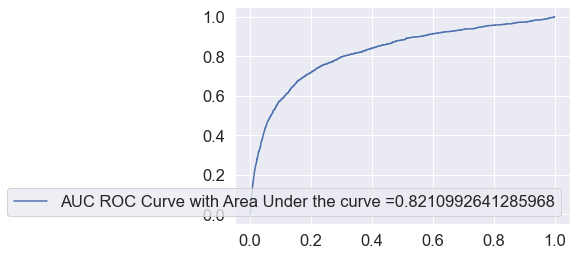

In [89]:
generate_auc_roc_curve_nb(clf_nb, X_test)

Text(0.5, 1.0, 'Precision-Recall curve')

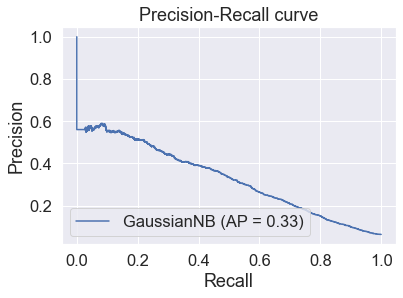

In [90]:
disp = plot_precision_recall_curve(clf_nb, X_test, Y_test)
disp.ax_.set_title('Precision-Recall curve')

#### 5) Uravnoteženje porazdelitve odvisne spremenljivke (class_weight='balanced')

In [91]:
print('X_train_lenght =', len(X_train))
print('Y_train_lenght =', len(Y_train))
print('X_test_lenght =', len(X_test))
print('Y_test_lenght =', len(Y_test))

X_train_lenght = 116403
Y_train_lenght = 116403
X_test_lenght = 29101
Y_test_lenght = 29101


In [92]:
Y_test.value_counts()

0    27240
1     1861
Name: SeriousDlqin2yrs, dtype: int64

In [93]:
Y_train.value_counts()

0    108711
1      7692
Name: SeriousDlqin2yrs, dtype: int64

In [94]:
# porazdelitev vrednosti odvisne spremenljivke
Y_train.value_counts(normalize=True),2

(0    0.933919
 1    0.066081
 Name: SeriousDlqin2yrs, dtype: float64, 2)

In [95]:
unique_classes = list(train['SeriousDlqin2yrs'].unique())
unique_classes

[1, 0]

In [96]:
out_dict = {}
for classes in unique_classes:
    out_dict[classes] = train.shape[0]/((train.loc[train['SeriousDlqin2yrs'] == classes].shape[0])
                                     *len(unique_classes))

In [97]:
out_dict

{1: 7.6156181304302315, 0: 0.5351339820964907}

In [98]:
print (X_test.shape, Y_test.shape)

(29101, 10) (29101,)


##### 5.1) LogisticRegression (class_weight='balanced')

In [99]:
clf_lr_2 = linear_model.LogisticRegression(class_weight='balanced', solver='liblinear')
#clf_lr_2.fit(X_train,Y_train)
clf_lr_2.fit(X_train,Y_train.values.ravel())

LogisticRegression(class_weight='balanced', solver='liblinear')

In [100]:
class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)

C:\Users\Miha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=82757     0
119950    0
131133    0
39306     0
42196     0
         ..
138940    0
143175    0
48813     1
69847     0
22226     1
Name: SeriousDlqin2yrs, Length: 116403, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([0.5353782 , 7.56649766])

In [101]:
Y_pred_lr_2 = clf_lr_2.predict(X_test)
pd.crosstab(Y_test, Y_pred_lr_2, rownames=['Actual'], colnames=['Predicted'], margins=True)
# pd.crosstab(pd.Series(Y_pred_lr_2, name = 'Predicted'),
#             pd.Series(Y_test['SeriousDlqin2yrs'], name = 'Actual'), margins=True)

Predicted,0,1,All
Actual,,,
0,21789,5451,27240
1,492,1369,1861
All,22281,6820,29101


In [102]:
len(Y_pred_lr_2)
len(Y_test)

29101

In [103]:
accuracy_score(Y_test, Y_pred_lr_2)

0.7957802137383595

In [104]:
roc_auc_score(Y_test, Y_pred_lr_2)

0.7677579376821234

In [105]:
print(classification_report(Y_test, Y_pred_lr_2))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27240
           1       0.20      0.74      0.32      1861

    accuracy                           0.80     29101
   macro avg       0.59      0.77      0.60     29101
weighted avg       0.93      0.80      0.84     29101



##### Iskanje optimalne nastavitve "weights"

In [106]:
weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)

grid_result = gsc.fit(X_train, Y_train.values.ravel())
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'class_weight': {0: 0.19210526315789472, 1: 0.8078947368421052}}


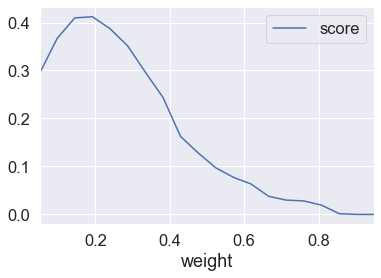

In [107]:
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
data_out.plot(x='weight')

In [108]:
print('max_data_out_score = ', max(data_out['score']))
data_out

## weight --> xxx

max_data_out_score =  0.4120291110507477


,score,weight
0,0.294008,0.050000
1,0.367010,0.097368
2,0.409691,0.144737
3,0.412029,0.192105
4,0.387065,0.239474
5,0.351233,0.286842
6,0.296641,0.334211
7,0.244050,0.381579
8,0.162568,0.428947
9,0.128239,0.476316


In [109]:
clf_lr_3 = linear_model.LogisticRegression(**grid_result.best_params_, solver='liblinear')
#clf_lr_2.fit(X_train,Y_train)
clf_lr_3.fit(X_train,Y_train.values.ravel())

LogisticRegression(class_weight={0: 0.19210526315789472, 1: 0.8078947368421052},
                   solver='liblinear')

In [110]:
Y_pred_lr_3 = clf_lr_3.predict(X_test)
pd.crosstab(Y_test, Y_pred_lr_3, rownames=['Actual'], colnames=['Predicted'], margins=True)
# pd.crosstab(pd.Series(Y_pred_lr_3, name = 'Predicted'),
#             pd.Series(Y_test['SeriousDlqin2yrs'], name = 'Actual'), margins=True)

Predicted,0,1,All
Actual,,,
0,26129,1111,27240
1,1101,760,1861
All,27230,1871,29101


In [111]:
accuracy_score(Y_test, Y_pred_lr_3)

0.9239888663619807

In [112]:
roc_auc_score(Y_test, Y_pred_lr_3)

0.6837984903037146

In [113]:
print(classification_report(Y_test, Y_pred_lr_3))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27240
           1       0.41      0.41      0.41      1861

    accuracy                           0.92     29101
   macro avg       0.68      0.68      0.68     29101
weighted avg       0.92      0.92      0.92     29101



##### 5.2) RandomForest (class_weight='balanced')

In [114]:
weights = np.linspace(0.05, 0.95, 20)
gsc_rf = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=19, max_depth = 9, random_state=0),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)

grid_result = gsc_rf.fit(X_train, Y_train.values.ravel())
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'class_weight': {0: 0.19210526315789472, 1: 0.8078947368421052}}


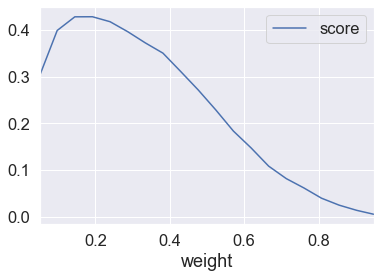

In [115]:
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'],
                         'weight': weights })
data_out.plot(x='weight')

In [116]:
print('max_data_out_score = ', max(data_out['score']))
data_out

## weight --> 0.192105

max_data_out_score =  0.42853156508054696


,score,weight
0,0.301722,0.050000
1,0.399095,0.097368
2,0.428370,0.144737
3,0.428532,0.192105
4,0.417891,0.239474
5,0.396549,0.286842
6,0.372498,0.334211
7,0.350528,0.381579
8,0.311443,0.428947
9,0.271702,0.476316


In [117]:
clf_rf_2 = RandomForestClassifier(**grid_result.best_params_, n_estimators=19, max_depth = 9, random_state=0)
#clf_lr_2.fit(X_train,Y_train)
clf_rf_2.fit(X_train,Y_train.values.ravel())

RandomForestClassifier(class_weight={0: 0.19210526315789472,
                                     1: 0.8078947368421052},
                       max_depth=9, n_estimators=19, random_state=0)

In [118]:
threshold_rf_2 = 0.5
predicted_proba_rf_2 = clf_rf_2.predict_proba(X_test)

Y_pred_rf_2 = (predicted_proba_rf_2 [:,1] >= threshold_rf_2).astype('int')

pd.crosstab(Y_test, Y_pred_rf_2, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,25880,1360,27240
1,1007,854,1861
All,26887,2214,29101


In [119]:
accuracy_score(Y_test, Y_pred_rf_2)

0.9186625889144703

In [120]:
roc_auc_score(Y_test, Y_pred_rf_2)

0.7044832448409702

In [121]:
print(classification_report(Y_test, Y_pred_rf_2))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     27240
           1       0.39      0.46      0.42      1861

    accuracy                           0.92     29101
   macro avg       0.67      0.70      0.69     29101
weighted avg       0.93      0.92      0.92     29101



In [122]:
def generate_auc_roc_curve_rf_2(clf_rf_2, X_test):
    Y_pred_rf_2 = clf_rf_2.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_rf_2)
    auc_rf_2 = roc_auc_score(Y_test, Y_pred_rf_2)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_rf_2))
    plt.legend(loc=4)
    plt.show()
    pass

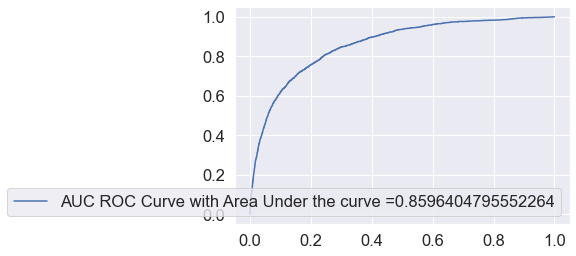

In [123]:
generate_auc_roc_curve_rf_2(clf_rf_2, X_test)

Text(0.5, 1.0, 'Precision-Recall curve')

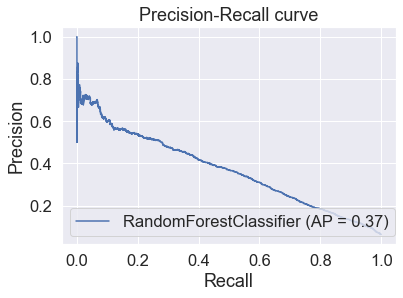

In [124]:
disp = plot_precision_recall_curve(clf_rf_2, X_test, Y_test)
disp.ax_.set_title('Precision-Recall curve')

##### 5.3) RandomForest (class_weight='balanced') & (best parameters)

In [125]:
# #tole traja več ur minut, zato nima smisla vsakič zaganjati (najboljše parametre sem že dobil)
# clf_rf_x = RandomForestClassifier()

# param_grid = {
#             'n_estimators': [140, 200, 250],
#             'max_features': [2, 4, 8, 'sqrt'],
#             'min_samples_leaf': [2, 4, 10],
#             'min_samples_split': [2, 5, 7],
#             'max_depth': [9, 12, 18],
#             'bootstrap': [True, False],
#             'criterion': ['gini', 'entropy']
#             }

# CV_rnd_cf3 = GridSearchCV(estimator = clf_rf_x, param_grid = param_grid, scoring = 'roc_auc', verbose = 10, n_jobs = -1)
# CV_rnd_cf3.fit(X_train, Y_train)

# best_parameters = CV_rnd_cf3.best_params_
# print("The best parameters: ", best_parameters)

In [126]:
# ##tole traja cca 15 minut, zato nima smisla vsakič zaganjati (najboljše parametre sem že dobil)
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 250, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

In [127]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# clf_rf_x = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = clf_rf_x, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# best_parameters = rf_random.best_params_
# print("The best parameters: ", best_parameters)
# # The best parameters:  {'n_estimators': 196, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

In [128]:
#%%tole traja cca 10 minut, zato nima smisla vsakič zaganjati (najboljše parametre sem že dobil)
# weights = np.linspace(0.05, 0.95, 20)
# gsc_rf = GridSearchCV(
#     estimator=RandomForestClassifier(n_estimators=200, max_features=2, min_samples_leaf=4, min_samples_split=5),
#     param_grid={
#         'class_weight': [{0: x, 1: 1.0-x} for x in weights]
#     },
#     scoring='f1',
#     cv=5
# )

# grid_result = gsc_rf.fit(X_train, Y_train.values.ravel())
# print("Best parameters : %s" % grid_result.best_params_)

In [129]:
train.dtypes

SeriousDlqin2yrs                           int64
RevolvingUtilizationOfUnsecuredLines     float64
age                                        int64
NumberOfTime30to59DaysPastDueNotWorse      int64
DebtRatio                                float64
MonthlyIncome                            float64
NumberOfOpenCreditLinesAndLoans            int64
NumberOfTimes90DaysLate                    int64
NumberRealEstateLoansOrLines               int64
NumberOfTime60to89DaysPastDueNotWorse      int64
NumberOfDependents                       float64
dtype: object

In [130]:
#class_weight: {0: 0.19210526315789472, 1: 0.8078947368421052}
#1) The best parameters:  {'max_depth': 12, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
#2) The best parameters:  {'n_estimators': 196, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
#3) The best parameters:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 12, 'max_features': 2, 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 140}

clf_rf_3 = RandomForestClassifier(class_weight={0: 0.19210526315789472, 1: 0.8078947368421052}, bootstrap='true', criterion='gini', max_depth = 12, max_features=2, min_samples_leaf=10, min_samples_split=7, n_estimators=140, random_state=0)
clf_rf_3.fit(X_train,Y_train.values.ravel())

RandomForestClassifier(bootstrap='true',
                       class_weight={0: 0.19210526315789472,
                                     1: 0.8078947368421052},
                       max_depth=12, max_features=2, min_samples_leaf=10,
                       min_samples_split=7, n_estimators=140, random_state=0)

In [131]:
threshold_rf_3 = 0.4
predicted_proba_rf_3 = clf_rf_3.predict_proba(X_test)

Y_pred_rf_3 = (predicted_proba_rf_3 [:,1] >= threshold_rf_3).astype('int')

pd.crosstab(Y_test, Y_pred_rf_3, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,25258,1982,27240
1,813,1048,1861
All,26071,3030,29101


In [132]:
accuracy_score(Y_test, Y_pred_rf_3)

0.9039551905432803

In [133]:
roc_auc_score(Y_test, Y_pred_rf_3)

0.7451887258441099

In [134]:
print(classification_report(Y_test, Y_pred_rf_3))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27240
           1       0.35      0.56      0.43      1861

    accuracy                           0.90     29101
   macro avg       0.66      0.75      0.69     29101
weighted avg       0.93      0.90      0.91     29101



In [135]:
def generate_auc_roc_curve_rf_3(clf_rf_3, X_test):
    Y_pred_rf_3 = clf_rf_3.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_rf_3)
    auc_rf_3 = roc_auc_score(Y_test, Y_pred_rf_3)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_rf_3))
    plt.legend(loc=4)
    plt.show()
    pass

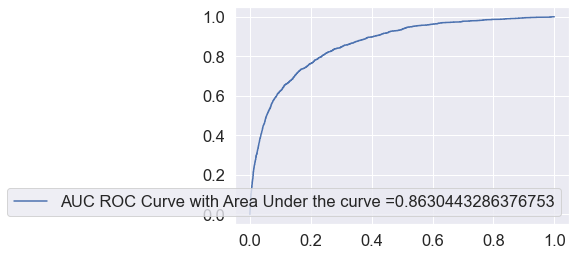

In [136]:
generate_auc_roc_curve_rf_3(clf_rf_3, X_test)

Text(0.5, 1.0, 'Precision-Recall curve')

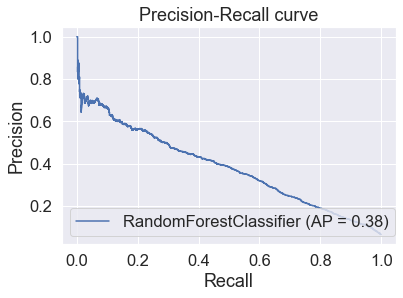

In [137]:
disp = plot_precision_recall_curve(clf_rf_3, X_test, Y_test)
disp.ax_.set_title('Precision-Recall curve')

##### 5.4) GradientBoosting Model

In [138]:
# tuning traja 8 ur zato ga ne izvajam vedno

##The best parameters:  {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


# clf_gb_x = GradientBoostingClassifier()

# param_grid = {
#             'loss': ['deviance', 'exponential'],
#             'learning_rate': [0.1, 0.3, 0.5, 0.7],
#             'n_estimators': [20, 50, 200],
#             'max_features': [2, 3, 4],
#             'min_samples_leaf': [1, 2, 4],
#             'min_samples_split': [2, 5, 10],
#             'max_depth': [6, 9, 12]
#             }

# CV_rnd_gb = GridSearchCV(estimator = clf_gb_x, param_grid = param_grid, scoring = 'roc_auc', verbose = 10, n_jobs = -1)
# CV_rnd_gb.fit(X_train, Y_train)

# best_parameters = CV_rnd_gb.best_params_
# print("The best parameters: ", best_parameters)

In [139]:
clf_gb = GradientBoostingClassifier(loss='exponential', n_estimators=50, learning_rate=0.1, max_features=3, max_depth=6, random_state=0, min_samples_leaf=1,min_samples_split=10)
clf_gb.fit(X_train,Y_train.values.ravel())

GradientBoostingClassifier(loss='exponential', max_depth=6, max_features=3,
                           min_samples_split=10, n_estimators=50,
                           random_state=0)

In [140]:
threshold_gb = 0.25
predicted_proba_gb = clf_gb.predict_proba(X_test)

Y_pred_gb = (predicted_proba_gb [:,1] >= threshold_gb).astype('int')

pd.crosstab(Y_test, Y_pred_gb, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,26137,1103,27240
1,1037,824,1861
All,27174,1927,29101


In [141]:
accuracy_score(Y_test, Y_pred_gb)

0.92646300814405

In [142]:
roc_auc_score(Y_test, Y_pred_gb)

0.7011403896031139

In [143]:
print(classification_report(Y_test, Y_pred_gb))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27240
           1       0.43      0.44      0.44      1861

    accuracy                           0.93     29101
   macro avg       0.69      0.70      0.70     29101
weighted avg       0.93      0.93      0.93     29101



In [144]:
def generate_auc_roc_curve_gb(clf_gb, X_test):
    Y_pred_gb = clf_gb.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_gb)
    auc_gb = roc_auc_score(Y_test, Y_pred_gb)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_gb))
    plt.legend(loc=4)
    plt.show()
    pass

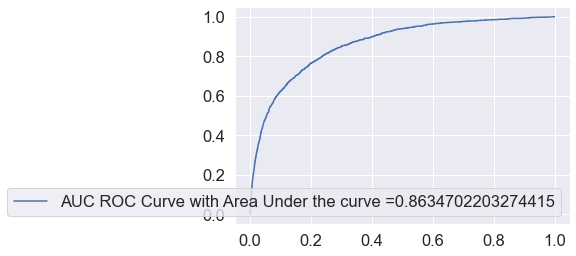

In [145]:
generate_auc_roc_curve_gb(clf_gb, X_test)

Text(0.5, 1.0, 'Precision-Recall curve')

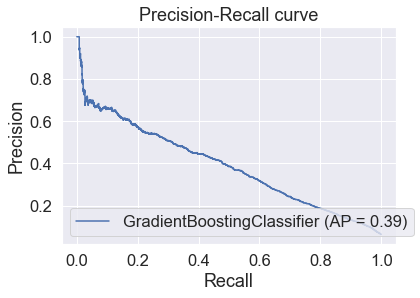

In [146]:
disp = plot_precision_recall_curve(clf_gb, X_test, Y_test)
disp.ax_.set_title('Precision-Recall curve')

##### 5.5) Ensemble Learning Model

In [147]:
print('DecisionTree = ', accuracy_score(Y_test, Y_pred_dt))
print('LogisticRegression = ', accuracy_score(Y_test, Y_pred_lr_3))
print('RandomForest1 = ', accuracy_score(Y_test, Y_pred_rf))
print('RandomForest2 = ', accuracy_score(Y_test, Y_pred_rf_2))
print('RandomForest3 = ', accuracy_score(Y_test, Y_pred_rf_3))
print('GradientBoosting = ', accuracy_score(Y_test, Y_pred_gb))
print('NeuralNetwork = ', accuracy_score(Y_test, Y_pred_nn))
print('NaiveBayes = ', accuracy_score(Y_test, Y_pred_nb))

DecisionTree =  0.7849214803614996
LogisticRegression =  0.9239888663619807
RandomForest1 =  0.916463351774853
RandomForest2 =  0.9186625889144703
RandomForest3 =  0.9039551905432803
GradientBoosting =  0.92646300814405
NeuralNetwork =  0.9358441290677296
NaiveBayes =  0.8994879901034328


In [148]:
#create a dictionary of our models
estimators_1=[('DecisionTree', clf_dt), ('LogisticRegression', clf_lr_3), ('RandomForest1', clf_rf), ('RandomForest2', clf_rf_2), ('RandomForest3', clf_rf_3), ('NeuralNetwork', clf_nn), ('NaiveBayes', clf_nb)]
estimators_2=[('LogisticRegression', clf_lr_3), ('RandomForest1', clf_rf), ('RandomForest2', clf_rf_2), ('RandomForest3', clf_rf_3), ('NaiveBayes', clf_nb)]
estimators_3=[('LogisticRegression', clf_lr_3), ('RandomForest3', clf_rf_3), ('NaiveBayes', clf_nb), ('GradientBoosting', clf_gb)]
estimators_4=[('RandomForest1', clf_rf), ('RandomForest2', clf_rf_2), ('RandomForest3', clf_rf_3), ('GradientBoosting', clf_gb)]

#create our voting classifier
ensemble_1 = VotingClassifier(estimators_1, voting='soft')
ensemble_2 = VotingClassifier(estimators_2, voting='soft')
ensemble_3 = VotingClassifier(estimators_3, voting='soft')
ensemble_4 = VotingClassifier(estimators_4, voting='soft')

In [149]:
#fit model to training data
ensemble_1.fit(X_train, Y_train)
ensemble_2.fit(X_train, Y_train)
ensemble_3.fit(X_train, Y_train)
ensemble_4.fit(X_train, Y_train)

VotingClassifier(estimators=[('RandomForest1',
                              RandomForestClassifier(max_depth=9,
                                                     n_estimators=19,
                                                     random_state=0)),
                             ('RandomForest2',
                              RandomForestClassifier(class_weight={0: 0.19210526315789472,
                                                                   1: 0.8078947368421052},
                                                     max_depth=9,
                                                     n_estimators=19,
                                                     random_state=0)),
                             ('RandomForest3',
                              RandomForestClassifier(bootstrap='true',
                                                     class_weight={0: 0.19210526315789472,
                                                                   1: 0.8078947368421052},
          

In [150]:
Y_pred_ensemble_1 = ensemble_1.predict(X_test)
pd.crosstab(Y_test, Y_pred_ensemble_1, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,26162,1078,27240
1,1067,794,1861
All,27229,1872,29101


In [151]:
print(classification_report(Y_test, Y_pred_ensemble_1))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27240
           1       0.42      0.43      0.43      1861

    accuracy                           0.93     29101
   macro avg       0.69      0.69      0.69     29101
weighted avg       0.93      0.93      0.93     29101



In [152]:
Y_pred_ensemble_2 = ensemble_2.predict(X_test)
pd.crosstab(Y_test, Y_pred_ensemble_2, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,25967,1273,27240
1,987,874,1861
All,26954,2147,29101


In [153]:
print(classification_report(Y_test, Y_pred_ensemble_2))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     27240
           1       0.41      0.47      0.44      1861

    accuracy                           0.92     29101
   macro avg       0.69      0.71      0.70     29101
weighted avg       0.93      0.92      0.92     29101



In [154]:
Y_pred_ensemble_3 = ensemble_3.predict(X_test)
pd.crosstab(Y_test, Y_pred_ensemble_3, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,25968,1272,27240
1,996,865,1861
All,26964,2137,29101


In [155]:
print(classification_report(Y_test, Y_pred_ensemble_3))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     27240
           1       0.40      0.46      0.43      1861

    accuracy                           0.92     29101
   macro avg       0.68      0.71      0.70     29101
weighted avg       0.93      0.92      0.92     29101



In [156]:
Y_pred_ensemble_4 = ensemble_4.predict(X_test)
pd.crosstab(Y_test, Y_pred_ensemble_4, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,26689,551,27240
1,1303,558,1861
All,27992,1109,29101


In [157]:
print(classification_report(Y_test, Y_pred_ensemble_4))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27240
           1       0.50      0.30      0.38      1861

    accuracy                           0.94     29101
   macro avg       0.73      0.64      0.67     29101
weighted avg       0.92      0.94      0.93     29101



In [158]:
def generate_auc_roc_curve_ensemble_1(ensemble_1, X_test):
    Y_pred_ensemble_1 = ensemble_1.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_ensemble_1)
    auc_ensemble_1 = roc_auc_score(Y_test, Y_pred_ensemble_1)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_ensemble_1))
    plt.legend(loc=4)
    plt.show()
    pass

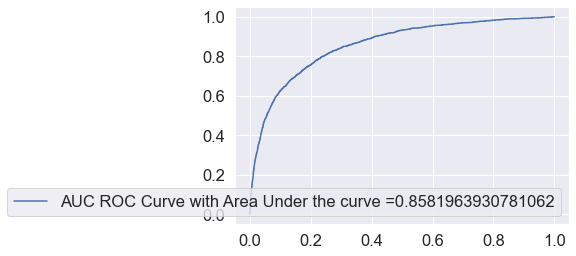

In [159]:
generate_auc_roc_curve_ensemble_1(ensemble_1, X_test)

Text(0.5, 1.0, 'Precision-Recall curve')

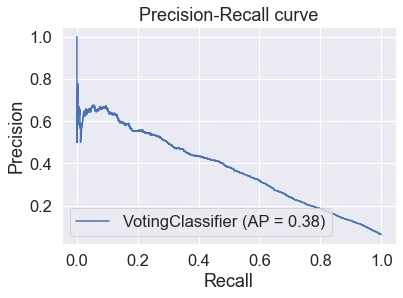

In [160]:
disp = plot_precision_recall_curve(ensemble_1, X_test, Y_test)
disp.ax_.set_title('Precision-Recall curve')

In [161]:
def generate_auc_roc_curve_ensemble_2(ensemble_2, X_test):
    Y_pred_ensemble_2 = ensemble_2.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_ensemble_2)
    auc_ensemble_2 = roc_auc_score(Y_test, Y_pred_ensemble_2)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_ensemble_2))
    plt.legend(loc=4)
    plt.show()
    pass

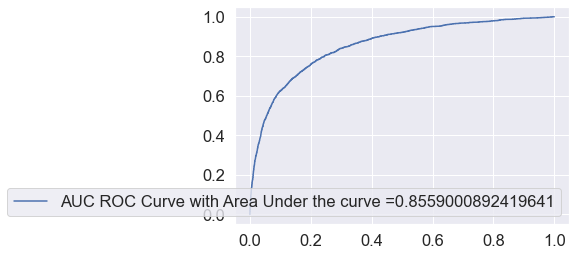

In [162]:
generate_auc_roc_curve_ensemble_2(ensemble_2, X_test)

Text(0.5, 1.0, 'Precision-Recall curve')

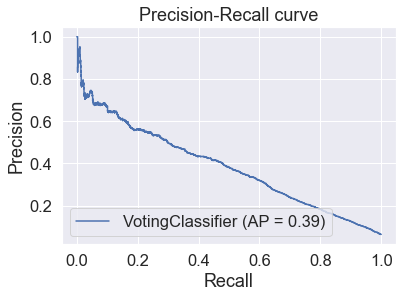

In [163]:
disp = plot_precision_recall_curve(ensemble_2, X_test, Y_test)
disp.ax_.set_title('Precision-Recall curve')

In [164]:
def generate_auc_roc_curve_ensemble_3(ensemble_3, X_test):
    Y_pred_ensemble_3 = ensemble_3.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_ensemble_3)
    auc_ensemble_3 = roc_auc_score(Y_test, Y_pred_ensemble_3)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_ensemble_3))
    plt.legend(loc=4)
    plt.show()
    pass

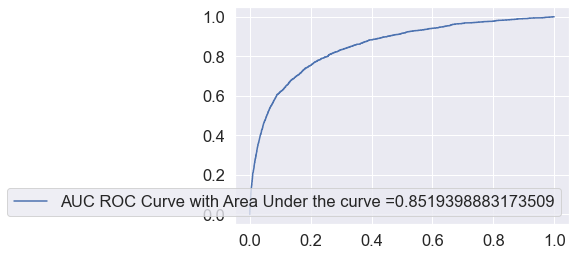

In [165]:
generate_auc_roc_curve_ensemble_3(ensemble_3, X_test)

Text(0.5, 1.0, 'Precision-Recall curve')

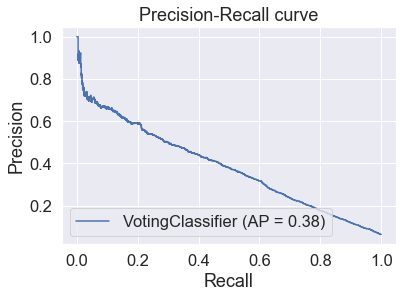

In [166]:
disp = plot_precision_recall_curve(ensemble_3, X_test, Y_test)
disp.ax_.set_title('Precision-Recall curve')

In [167]:
def generate_auc_roc_curve_ensemble_4(ensemble_4, X_test):
    Y_pred_ensemble_4 = ensemble_4.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_ensemble_4)
    auc_ensemble_4 = roc_auc_score(Y_test, Y_pred_ensemble_4)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_ensemble_4))
    plt.legend(loc=4)
    plt.show()
    pass

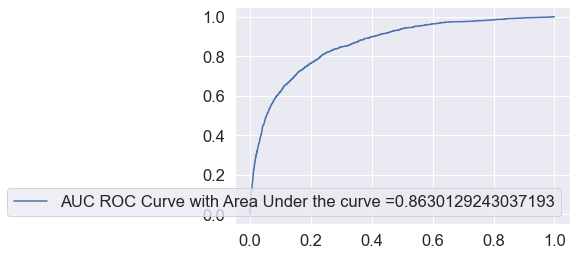

In [168]:
generate_auc_roc_curve_ensemble_4(ensemble_4, X_test)

Text(0.5, 1.0, 'Precision-Recall curve')

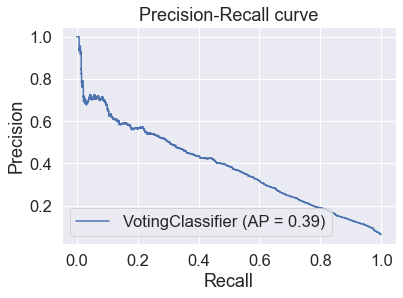

In [169]:
disp = plot_precision_recall_curve(ensemble_4, X_test, Y_test)
disp.ax_.set_title('Precision-Recall curve')

#### 6) Preverjanje ustreznosti modela

In [170]:
test = pd.read_csv(r"C:\Users\Miha\Desktop\Credit Scoring\cs-test.csv").drop('Unnamed: 0', axis = 1)
sampleEntry = pd.read_csv(r"C:\Users\Miha\Desktop\Credit Scoring\sampleEntry.csv")

In [171]:
test

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
101498,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0
101499,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0
101500,NaN,0.081596,70,0,836.000000,NaN,3,0,0,0,NaN
101501,NaN,0.335457,56,0,3568.000000,NaN,8,0,2,1,3.0


##### Ureditev testne baze 

In [172]:
## UREDIM NA ENAK NAČIN KOT TRAIN DF
test.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'NumberOfTime30to59DaysPastDueNotWorse'}, inplace=True)
test.rename(columns={'NumberOfTime60-89DaysPastDueNotWorse':'NumberOfTime60to89DaysPastDueNotWorse'}, inplace=True)


test["NumberOfTimes90DaysLate"].replace(96, 18, inplace = True)
test["NumberOfTimes90DaysLate"].replace(98, 19, inplace = True)
test["NumberOfTime30to59DaysPastDueNotWorse"].replace(96, 18, inplace = True)
test["NumberOfTime30to59DaysPastDueNotWorse"].replace(98, 19, inplace = True)
test["NumberOfTime60to89DaysPastDueNotWorse"].replace(96, 18, inplace = True)
test["NumberOfTime60to89DaysPastDueNotWorse"].replace(98, 19, inplace = True)

#null vrednost zamenjam z 0
test["NumberOfDependents"].fillna(0, inplace = True)
#NAN vrednosti nadomestim z 0
test["NumberOfDependents"].replace(np.nan, 0, inplace=True)

#NAN vrednosti nadomestim z mediano
median_MonthlyIncome2 = test["MonthlyIncome"].astype("float").median(axis=0)
test["MonthlyIncome"].replace(np.nan, median_MonthlyIncome2, inplace=True)
#vrednosti med 0 in 10 nadomestim z mediano
test['MonthlyIncome'] = np.where(test['MonthlyIncome'].between(0,10), median_MonthlyIncome2, test['MonthlyIncome'])

In [173]:
# pred dropom 'SeriousDlqin2yrs' pripravim file za Danijev test (Spark)
test.to_csv(r'C:\Users\Miha\Desktop\Credit Scoring\test_MJ.csv', index = False)

In [174]:
test=test.drop(["SeriousDlqin2yrs"],1)

In [175]:
test

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
0,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...
101498,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0
101499,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0
101500,0.081596,70,0,836.000000,5400.0,3,0,0,0,0.0
101501,0.335457,56,0,3568.000000,5400.0,8,0,2,1,3.0


##### 6.1) Ocena za RandomForestClassifier

In [176]:
result_RandomForest=clf_rf_2.predict_proba(test)[:,1]

In [177]:
result_RandomForest

array([0.24059319, 0.13402168, 0.06222543, ..., 0.02354648, 0.21494894,
       0.13457472])

In [178]:
sampleEntry["Probability"]=result_RandomForest
sampleEntry.tail()

,Id,Probability
101498,101499,0.096160
101499,101500,0.536811
101500,101501,0.023546
101501,101502,0.214949
101502,101503,0.134575


In [179]:
sampleEntry.to_csv(r'C:\Users\Miha\Desktop\Credit Scoring\Result\sampleEntry_RandomForest.csv', index = False)

##### 6.2) Ocena za VotingClassifier - Ensemble Learning Model (ensemble_2 & ensemble_3 & ensemble_4)

In [180]:
result_ensemble_2 = ensemble_2.predict_proba(test)[:,1]

In [181]:
result_ensemble_2

array([0.30684401, 0.23452345, 0.10329223, ..., 0.04860409, 0.13828888,
       0.21802416])

In [182]:
sampleEntry["Probability"]=result_ensemble_2
sampleEntry.tail()

,Id,Probability
101498,101499,0.175785
101499,101500,0.641706
101500,101501,0.048604
101501,101502,0.138289
101502,101503,0.218024


In [183]:
sampleEntry.to_csv(r'C:\Users\Miha\Desktop\Credit Scoring\Result\sampleEntry_ensemble_2.csv', index = False)

In [184]:
result_ensemble_3 = ensemble_3.predict_proba(test)[:,1]

In [185]:
result_ensemble_3

array([0.32106013, 0.26192286, 0.11271326, ..., 0.05411337, 0.10302032,
       0.24020077])

In [186]:
sampleEntry["Probability"]=result_ensemble_3
sampleEntry.tail()

,Id,Probability
101498,101499,0.197125
101499,101500,0.676904
101500,101501,0.054113
101501,101502,0.103020
101502,101503,0.240201


In [187]:
sampleEntry.to_csv(r'C:\Users\Miha\Desktop\Credit Scoring\Result\sampleEntry_ensemble_3.csv', index = False)

In [188]:
result_ensemble_4 = ensemble_4.predict_proba(test)[:,1]

In [189]:
result_ensemble_4

array([0.15466356, 0.08507121, 0.03763399, ..., 0.01441794, 0.16306283,
       0.08418017])

In [190]:
sampleEntry["Probability"]=result_ensemble_4
sampleEntry.tail()

,Id,Probability
101498,101499,0.060561
101499,101500,0.459202
101500,101501,0.014418
101501,101502,0.163063
101502,101503,0.084180


In [191]:
sampleEntry.to_csv(r'C:\Users\Miha\Desktop\Credit Scoring\Result\sampleEntry_ensemble_4.csv', index = False)

##### 6.3) Ocena za RandomForestClassifier_3

In [192]:
result_RandomForest_3=clf_rf_3.predict_proba(test)[:,1]

In [193]:
result_RandomForest_3

array([0.22850502, 0.11825528, 0.06026369, ..., 0.02215924, 0.20708966,
       0.13156538])

In [194]:
sampleEntry["Probability"]=result_RandomForest_3
sampleEntry.tail()

,Id,Probability
101498,101499,0.095708
101499,101500,0.601267
101500,101501,0.022159
101501,101502,0.207090
101502,101503,0.131565


In [195]:
sampleEntry.to_csv(r'C:\Users\Miha\Desktop\Credit Scoring\Result\sampleEntry_RandomForest_3.csv', index = False)

##### 6.4) Ocena za GradientBoosting

In [196]:
result_gr=clf_gb.predict_proba(test)[:,1]

In [197]:
sampleEntry["Probability"]=result_gr
sampleEntry.tail()

,Id,Probability
101498,101499,0.028056
101499,101500,0.367315
101500,101501,0.004473
101501,101502,0.082899
101502,101503,0.037919


In [198]:
sampleEntry.to_csv(r'C:\Users\Miha\Desktop\Credit Scoring\Result\sampleEntry_GradientBoosting.csv', index = False)

### NAJBOLJŠI MODEL

Najboljšo oceno sem dosegel z RandomForestClassifier & GradientBoosting, kjer je izvedena GridSearchCV za class_weight in ostale parametre. Modela dosegata rezultat accuracy = cca 0,93, ROC_AUC = 0,868 ter F1-score = 0,45 (recall=0,44, precision=0,45)

In [199]:
pd.crosstab(Y_test, Y_pred_rf_3, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,25258,1982,27240
1,813,1048,1861
All,26071,3030,29101


In [200]:
print(classification_report(Y_test, Y_pred_rf_3))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27240
           1       0.35      0.56      0.43      1861

    accuracy                           0.90     29101
   macro avg       0.66      0.75      0.69     29101
weighted avg       0.93      0.90      0.91     29101



#### RandomForest ROC

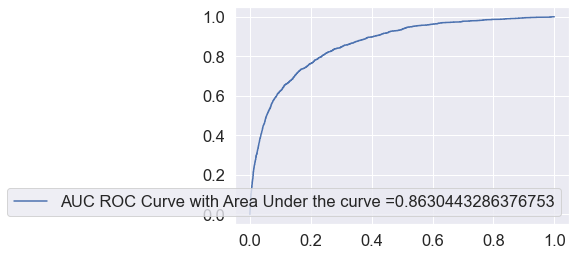

In [201]:
generate_auc_roc_curve_rf_3(clf_rf_3, X_test)

#### GradientBoosting ROC

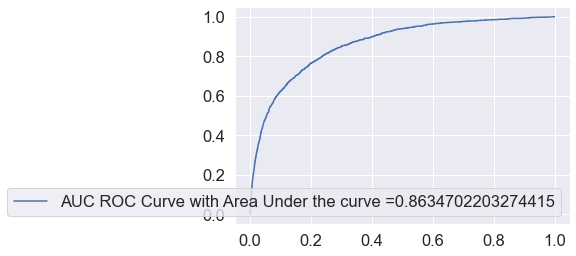

In [202]:
generate_auc_roc_curve_rf_3(clf_gb, X_test)

#### ensemble_4 ROC

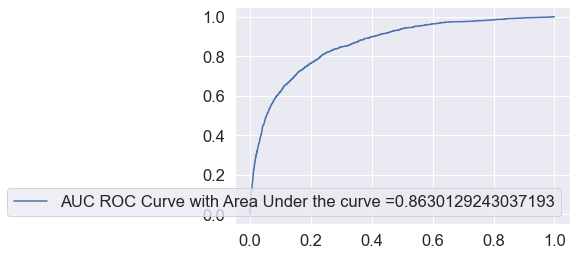

In [203]:
generate_auc_roc_curve_ensemble_4(ensemble_4, X_test)

Dobre rezultate dosegajo tudi različni Ensemble Learning Model-i, ki kombinirajo različne tehnike.